# **Experiments with CNN -- Movie Genre Classification based on Poster Images**



Description : 

In this notebook we are going to develop a deep neural network (CNN) to solve the problem of movie genre classification based on movie poster images.

Data Source : https://www.cs.ccu.edu.tw/~wtchu/projects/MoviePoster/index.html

The following is the video articulating the concepts
https://www.youtube.com/playlist?list=PLkEQhv7sdYRJydMA3U4HEKod-7DgMQEyy

Reference Links: 

If you are new to Convolution and Pooling concepts 

*   Play with this notebook https://colab.research.google.com/drive/1_s6r49qhhk6kDCCDhKYsnBU_fjiQILB0 which gives you a view of how Convolution and Pooling works

*   Please also go through the videos by Andrew NG at 
https://www.youtube.com/playlist?list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF . The playlist is long but you can hop onto this experiment once you are done till C4W1L11, that will give you a good foundation on Convolution and Pooling







In [1]:
import os
import zipfile
import random
import tensorflow as tf
import shutil
import csv
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras import Model
from shutil import copyfile
import pandas as pd
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16
#from keras.utils.vis_utils import plot_model

import graphviz
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
import tensorflow as tf
tf.__version__

'2.0.0'

## **Building a Master File List**

In [3]:
%ls groundtruth > fileList.txt
%ls groundtruth

 Volume in drive C is BOOTCAMP
 Volume Serial Number is A612-24EF

 Directory of C:\Users\Admin\MultiLabelClassification\groundtruth

05/18/2020  08:06 AM    <DIR>          .
05/18/2020  08:06 AM    <DIR>          ..
05/18/2020  08:06 AM            72,871 1980.txt
05/18/2020  08:06 AM            69,897 1981.txt
05/18/2020  08:06 AM           168,488 1982.txt
05/18/2020  08:06 AM           176,030 1983.txt
05/18/2020  08:06 AM           210,046 1984.txt
05/18/2020  08:06 AM           232,144 1985.txt
05/18/2020  08:06 AM           264,042 1986.txt
05/18/2020  08:06 AM           287,660 1987.txt
05/18/2020  08:06 AM           313,834 1988.txt
05/18/2020  08:06 AM           276,338 1989.txt
05/18/2020  08:06 AM           255,800 1990.txt
05/18/2020  08:06 AM           266,588 1991.txt
05/18/2020  08:06 AM           269,152 1992.txt
05/18/2020  08:06 AM           303,250 1993.txt
05/18/2020  08:06 AM           297,304 1994.txt
05/18/2020  08:06 AM           324,276 1995.txt
05/18/2020  08:

In [4]:
fileList = []
with open("file_list_txt.txt") as f:
  for line in f:
    fileList.append(line.strip())

## **Data Consolidation**

A a single directory to consolidate all the posteres

In [5]:
#allmoviepostersdata_dir = 'allmoviepostersdata'
#os.mkdir(allmoviepostersdata_dir)

## **Master File List Table**

Iterate through all the metadata files and build a single master table. As you can see the that there are no posters for 1982 which needs be taken into account. Essentially there could be metadata for non existent poster files or there could be poster files for which there is no metadata. This data anomaly has to be factored in while processing the files.

In [6]:
moviePosterCount = []
movieYear = []
moviePosterFile = []
for loop in range(len(fileList)):
  dirName = os.path.join('Movie_Poster_Dataset',fileList[loop].replace(".txt",""))
  imageFileList = os.listdir(dirName)
  print('DirName:',dirName,' Year:',fileList[loop].replace(".txt",""),':',len(imageFileList))
  moviePosterCount.append(len(imageFileList))
  movieYear.append(fileList[loop].replace(".txt",""))
  for file in imageFileList:
    moviePosterFile.append(file)

DirName: Movie_Poster_Dataset\1980  Year: 1980 : 96
DirName: Movie_Poster_Dataset\1981  Year: 1981 : 89
DirName: Movie_Poster_Dataset\1982  Year: 1982 : 0
DirName: Movie_Poster_Dataset\1983  Year: 1983 : 114
DirName: Movie_Poster_Dataset\1984  Year: 1984 : 134
DirName: Movie_Poster_Dataset\1985  Year: 1985 : 150
DirName: Movie_Poster_Dataset\1986  Year: 1986 : 169
DirName: Movie_Poster_Dataset\1987  Year: 1987 : 187
DirName: Movie_Poster_Dataset\1988  Year: 1988 : 201
DirName: Movie_Poster_Dataset\1989  Year: 1989 : 180
DirName: Movie_Poster_Dataset\1990  Year: 1990 : 167
DirName: Movie_Poster_Dataset\1991  Year: 1991 : 171
DirName: Movie_Poster_Dataset\1992  Year: 1992 : 175
DirName: Movie_Poster_Dataset\1993  Year: 1993 : 192
DirName: Movie_Poster_Dataset\1994  Year: 1994 : 191
DirName: Movie_Poster_Dataset\1995  Year: 1995 : 206
DirName: Movie_Poster_Dataset\1996  Year: 1996 : 210
DirName: Movie_Poster_Dataset\1997  Year: 1997 : 204
DirName: Movie_Poster_Dataset\1998  Year: 1998 : 2

In [7]:
movieListDatabase = pd.DataFrame({'MovieYear':movieYear,'MoviePosterCount':moviePosterCount})

In [8]:
movieListDatabase.head()

,MovieYear,MoviePosterCount
0,1980,96
1,1981,89
2,1982,0
3,1983,114
4,1984,134


In [9]:
print("As per the metadata there has to be ",movieListDatabase["MoviePosterCount"].sum()," movie posters")

As per the metadata there has to be  8052  movie posters


In [10]:
fileList[1]

'1981.txt'

## **Iterating through the Metadata to extract other relevant information**

Here is a quick and dirty version of reading the corresponding metadata files. During exploratory analysis, found some differences in the file metadata. Prior to 1982 the files could be read using "utf-8" while others could be read only using "utf-16". This is not the best code but serves the purpose of collecting relevant information.

In [11]:
movieList = []
movieDict ={}
count = 0
for loop in range(len(fileList)):
  recCount = 0
  if (movieListDatabase["MoviePosterCount"][loop]>0):
    recCount = 0
    fileName = os.path.join('groundtruth',fileList[loop])
    try:
      with open(fileName,encoding='utf-8') as f:
          for line in f:
            modline = line.strip()
            if (modline=="{"):
              movieDict["Year"] = fileList[loop].replace(".txt","").strip()
              count = count+1
            elif (modline=="}"):
              movieList.append(movieDict)
              movieDict ={}
              count = count-1
            else:
              movieDict[modline.split(":")[0].replace('"', '').strip()] = modline.split(":")[1].replace('"', '').strip()
              recCount = recCount+1
    except:
        with open(fileName,encoding='utf-16') as f:
          for line in f:
            modline = line.strip()
            if (modline=="{"):
              movieDict["Year"] = fileList[loop].replace(".txt","").strip()
              count = count+1
            elif (modline=="}"):
              movieList.append(movieDict)
              movieDict ={}
              count = count-1
            else:
              movieDict[modline.split(":")[0].replace('"', '').strip()] = modline.split(":")[1].replace('"', '').strip()
              recCount = recCount+1

In [12]:
movieList[1]

{'Actors': 'Gene Wilder, Richard Pryor, Georg Stanford Brown, JoBeth Williams,',
 'Awards': '1 nomination.,',
 'Box_office': '101,500,000,',
 'Country': 'USA,',
 'Director': 'Sidney Poitier,',
 'Genre': 'Comedy, Crime,',
 'Language': 'English,',
 'Metascore': '50',
 'Poster': 'http',
 'Rated': 'R,',
 'Released': '12 Dec 1980,',
 'Response': 'True,',
 'Runtime': '111 min,',
 'Title': 'Stir Crazy,',
 'Type': 'movie,',
 'Writer': 'Bruce Jay Friedman,',
 'Year': '1980',
 '_id': 'ObjectId(56fb860e71a0651b0c306f56),',
 'imdbID': 'tt0081562,',
 'imdbRating': '6.8,',
 'imdbVotes': '17,705,'}

## **Building the database of actual existent files**

Iterates through the movieList and find if there is a corresponding movie poster file existent. If its existent it moves them to the new directory that was created to place all the movie posters.

In [13]:
mainPosterDirectory = 'Movie_Poster_Dataset'
allmoviepostersdata_dir = 'allmoviepostersdata'
scrubbedMovieList = []
newFileList = []
for loop in range(len(movieList)):
  filePosterDirectory = os.path.join(mainPosterDirectory,movieList[loop]['Year'])
  fileName = movieList[loop]["imdbID"].replace(",","").strip()
  actualFileName = os.path.join(filePosterDirectory,fileName)+".jpg"
  if (len([file for file in newFileList if file==fileName])==0):
    newFileList.append(fileName)
    if(os.path.isfile(actualFileName)):
      scrubbedMovieList.append(movieList[loop])
      destFileName = movieList[loop]["imdbID"].replace(",","").strip()+".jpg"
      destFileNameWithPath = os.path.join(allmoviepostersdata_dir,destFileName)
      shutil.copyfile(actualFileName,destFileNameWithPath)

In [14]:
print("Size of scrubbedMovieList is ",len(scrubbedMovieList))

Size of scrubbedMovieList is  8052


In [15]:
allGenreList = []
for loop in range(len(scrubbedMovieList)):
  allGenreList.append(','.join([elem for elem in scrubbedMovieList[loop]['Genre'].split(",") if elem!=""]))


In [16]:
fileNameList =[elem["imdbID"].replace(",","").strip()+".jpg" for elem in scrubbedMovieList]

In [17]:
movieListDatabase = pd.DataFrame({'FileNames':fileNameList,'Genres':allGenreList})

In [18]:
movieListDatabase.head()

,FileNames,Genres
0,tt0080684.jpg,"Action, Adventure, Fantasy"
1,tt0081562.jpg,"Comedy, Crime"
2,tt0080339.jpg,Comedy
3,tt0080377.jpg,"Action, Comedy"
4,tt0081375.jpg,"Comedy, War"


In [19]:
movieListDatabase["Genres"]=movieListDatabase["Genres"].apply(lambda x:x.split(","))

In [20]:
movieListDatabase.head()

,FileNames,Genres
0,tt0080684.jpg,"[Action, Adventure, Fantasy]"
1,tt0081562.jpg,"[Comedy, Crime]"
2,tt0080339.jpg,[Comedy]
3,tt0080377.jpg,"[Action, Comedy]"
4,tt0081375.jpg,"[Comedy, War]"


In [21]:
genreList = ""
for loop in range(len(scrubbedMovieList)):
  if (genreList==""):
    genreList = scrubbedMovieList[loop]['Genre']
  else:
    genreList = genreList+","+scrubbedMovieList[loop]['Genre']

In [22]:
genreSet = [elem.strip() for elem in genreList.split(',') if elem!=""]

In [23]:
genreSet = set(genreSet)

In [24]:
genreSetList = list(genreSet)

In [25]:
genreSetList.sort()

In [26]:
print(genreSetList)

['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'N/A', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western']


In [27]:
genre_list = []
for genre in genreSetList:
    genre_list.append([genre])

### New Code For multi label classification

In [28]:
labels = genre_list
mlb = MultiLabelBinarizer()
mlb.fit(labels)
#MultiLabelBinarizer(classes=None, sparse_output=False)
mlb.classes_

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'N/A', 'News', 'Reality-TV',
       'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War',
       'Western'], dtype=object)

In [29]:
Y = mlb.transform(movieListDatabase["Genres"])
Y

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## **Viewing the Posters and the respective Genres**

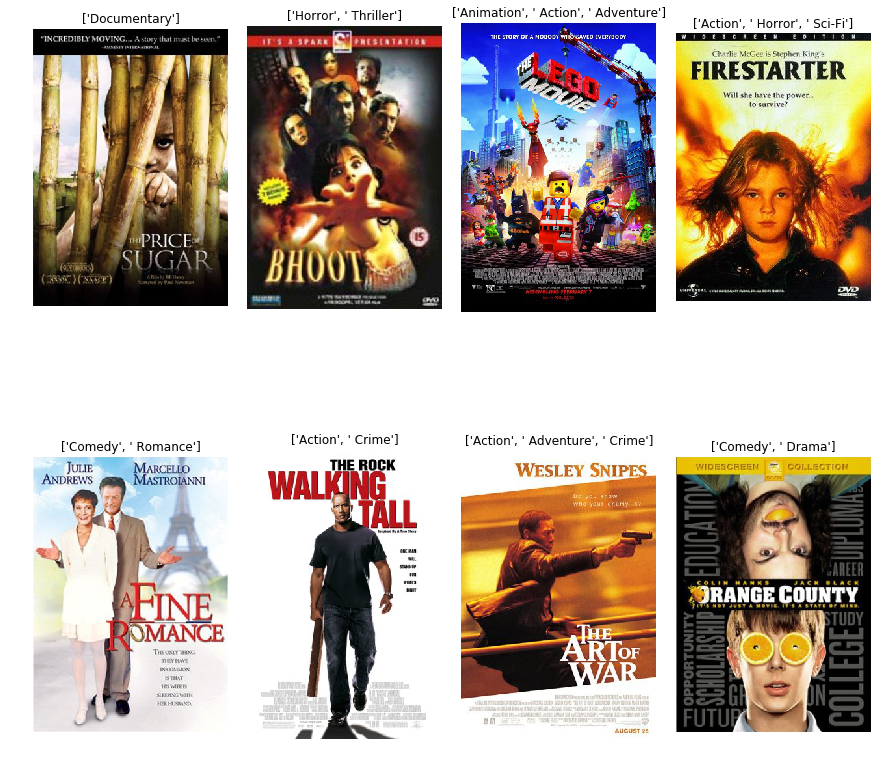

In [30]:
sampledMovies = movieListDatabase.sample(frac=.001)
maxCols = 4
maxRows = sampledMovies.shape[0]//maxCols
fig, axes = plt.subplots(nrows=maxRows, ncols=maxCols, figsize=(15,15))
row = 0
col = 0
for loop in range(sampledMovies.shape[0]):
    img_path = os.path.join(allmoviepostersdata_dir,sampledMovies.iloc[loop]["FileNames"])
    img = mpimg.imread(img_path)
    if (col > (maxCols-1)):
      row = row + 1
      col = 0
    axes[row, col].axis("off")
    axes[row, col].set_title(sampledMovies.iloc[loop]["Genres"])
    axes[row, col].imshow(img)  
    col = col + 1
plt.subplots_adjust(wspace=.10, hspace=.10)
plt.show()

## **Shuffling the dataset**

In [31]:
movieListDatabase = movieListDatabase.sample(frac=1).reset_index(drop=True)
movieListDatabase.head(100)

,FileNames,Genres
0,tt0111359.jpg,"[Adventure, Family, Fantasy]"
1,tt2909116.jpg,[Adventure]
2,tt0093378.jpg,"[Biography, Drama, Music]"
3,tt0100680.jpg,"[Drama, Romance]"
4,tt0094747.jpg,"[Biography, Drama, Music]"
...,...,...
95,tt1531706.jpg,"[Animation, Family]"
96,tt0099300.jpg,[Drama]
97,tt0139462.jpg,"[Drama, Romance]"
98,tt3093520.jpg,"[Documentary, Biography, News]"


### Taking just 2000 records so that it runs in my Desktop (Extra code)

In [32]:
trainData, validationData = train_test_split(movieListDatabase.head(100), test_size=0.2, random_state=42)

print(trainData.shape)
print(validationData.shape)

(80, 2)
(20, 2)


In [33]:
type(list(mlb.classes_))
mlb.classes_ = list(mlb.classes_)

# **Modelling**
Here the attribute classes has been changed

In [34]:
train_datagen=ImageDataGenerator(rescale=1./255.)
valid_datagen=ImageDataGenerator(rescale=1./255.)
targetSize = 224

train_generator=train_datagen.flow_from_dataframe(
      dataframe=trainData,
      directory="allmoviepostersdata",
      x_col="FileNames",
      y_col="Genres",
      batch_size=50,
      shuffle=True,
      class_mode="categorical",
      classes=mlb.classes_, # code change
      target_size=(targetSize,targetSize)
)

valid_generator=valid_datagen.flow_from_dataframe(
      dataframe=validationData,
      directory="allmoviepostersdata",
      x_col="FileNames",
      y_col="Genres",
      batch_size=10,
      shuffle=True,
      class_mode="categorical",
      classes=mlb.classes_, # code change
      target_size=(targetSize,targetSize)
)

Found 80 validated image filenames belonging to 25 classes.
Found 20 validated image filenames belonging to 25 classes.


In [35]:
maxPooling = 4
filterSize = 3
nodeCount = 64
dropOut = 0.3
'''
model = tf.keras.models.Sequential([                 
    tf.keras.layers.Conv2D(nodeCount, (filterSize, filterSize), activation='relu', input_shape=(targetSize, targetSize, 3), padding="valid"),
    tf.keras.layers.MaxPooling2D(maxPooling, maxPooling),    
    tf.keras.layers.Dropout(dropOut),                 
    tf.keras.layers.Conv2D(nodeCount, (filterSize, filterSize), activation='relu', input_shape=(targetSize, targetSize, 3), padding="valid"),
    tf.keras.layers.MaxPooling2D(maxPooling, maxPooling),       
    tf.keras.layers.Dropout(dropOut),                                         
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(nodeCount, activation=tf.nn.relu), 
    tf.keras.layers.Dense(len(mlb.classes_), activation=tf.nn.sigmoid)])  # using sigmoid
'''

#Get back the convolutional part of a VGG network trained on ImageNet
model = VGG16(weights='imagenet', include_top=True)

In [36]:
for layer in model.layers:
    layer.trainable = False
#model.trainable = False

In [37]:
#Removing the last layer having 1000, nodes AND adding 2 more layers with 512 & 25 nodes
x = Dense(25, activation='sigmoid', name='fc3')(model.layers[-2].output)
#x = Dense(25, activation='sigmoid', name='predictions')(x)
model = Model(model.input, x)

In [38]:
for layer in model.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False
flatten False
fc1 False
fc2 False
fc3 True


In [39]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
model.compile(optimizer = "adam",
              loss = 'categorical_crossentropy',
              metrics=['accuracy','categorical_crossentropy'])

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
print("STEP_SIZE_TRAIN :",STEP_SIZE_TRAIN)
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
print("STEP_SIZE_VALID :",STEP_SIZE_VALID)
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=1
)

STEP_SIZE_TRAIN : 1
STEP_SIZE_VALID : 2


In [ ]:
model.weights

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()


# Desired output. Charts with training and validation metrics. No crash :)

### Taking a image and doing prediction on it.

In [ ]:
# predicting images
reverseLabelLookup = {value:key for key,value in train_generator.class_indices.items()}
img = image.load_img('tt0104714.jpg', target_size=(224, 224, 3))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
output = model.predict(images, batch_size=10)

print(mlb.classes_)
print("\n We are getting the output as :-")
print(output)
#print(classes)
plt.imshow(img)
print("\nThe Genre of the movie are:-")
for i in range(output.shape[1]):
    if output[0,i] == 1:
        print(reverseLabelLookup[i])


#print("Predicted Movie Genre is ",reverseLabelLookup[np.argmax(mlb.classes_)])
#print("Actual Movie Genre is ",movieListDatabase[movieListDatabase["FileNames"]==fn]["Genres"].to_string(index=False))

#print(classes)